In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,'/content/drive/My Drive/MSc_Project_Colab/BAD_PyTorch/')

In [ ]:
!pip install torchaudio

In [ ]:
!pip install tensorboard
!tensorboard --logdir=runs

**CNN**

In [4]:
from torch import nn
from torchsummary import summary


class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding='valid'
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding='valid'
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d(kernel_size=3)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding='valid'
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding='valid'
            ),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.001),
            nn.MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.5)
        self.linearA = nn.Linear(448, 256)
        self.batchnormA = nn.BatchNorm1d(256)
        self.leakyrelu = nn.LeakyReLU(0.001)
        self.linearB = nn.Linear(256, 32)
        self.batchnormB = nn.BatchNorm1d(32)

        self.linear = nn.Linear(32, 1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.linearA(x)
        x = self.batchnormA(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        x = self.linearB(x)
        x = self.batchnormB(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)
        logits = self.linear(x)

        # predictions = self.sigmoid(logits)
        return logits


if __name__ == "__main__":
    cnn = CNNNetwork()
    summary(cnn.cuda(), (1, 80, 698))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 78, 696]             160
       BatchNorm2d-2          [-1, 16, 78, 696]              32
         LeakyReLU-3          [-1, 16, 78, 696]               0
         MaxPool2d-4          [-1, 16, 26, 232]               0
            Conv2d-5          [-1, 16, 24, 230]           2,320
       BatchNorm2d-6          [-1, 16, 24, 230]              32
         LeakyReLU-7          [-1, 16, 24, 230]               0
         MaxPool2d-8            [-1, 16, 8, 76]               0
            Conv2d-9            [-1, 16, 6, 74]           2,320
      BatchNorm2d-10            [-1, 16, 6, 74]              32
        LeakyReLU-11            [-1, 16, 6, 74]               0
        MaxPool2d-12            [-1, 16, 6, 24]               0
           Conv2d-13            [-1, 16, 4, 22]           2,320
      BatchNorm2d-14            [-1, 16

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train the model

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/DCASE_Datasets/audio/ff1010bird/167401.wav
/content/drive/My Drive/DCASE_Datasets/audio/ff1010bird/155283.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/014a02c9-0fd4-4d13-a98b-82ce03e817c8.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/fcad3cc7-dbe8-4986-a45b-2b1daf3b34d0.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/0571511f-1649-4973-a370-27f9b99c34c1.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/02e65503-47db-444d-a863-bbc99a1925b5.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/fdebfd52-effc-461b-a27b-c3cae8e552e9.wav
/content/drive/My Drive/DCASE_Datasets/audio/ff1010bird/70892.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/ff978688-a9ec-4c48-a4ce-7bdaad33b645.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/02e812ef-ac67-44ab-a3e3-9b90b450016c.wav
/content/drive/My Dri

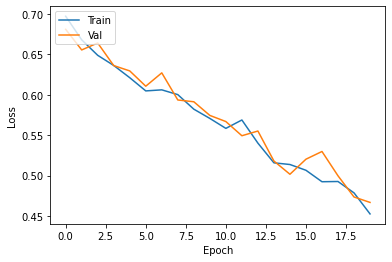

In [58]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchaudio

from random import seed
from random import random
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from dcasedataset import DCASE_Dataset

ANNOTATIONS_FILE_TRAIN = '/content/drive/My Drive/DCASE_Datasets/labels/bv_ff_1200.csv'
ANNOTATIONS_FILE_VAL = '/content/drive/My Drive/DCASE_Datasets/labels/mini_metadata.csv'
AUDIO_DIR = '/content/drive/My Drive/DCASE_Datasets/audio/'
SAMPLE_RATE = 22050
DURATION = 10
NUM_SAMPLES = 22050 * DURATION


BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.001

def create_data_loader(train_data, val_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader, val_dataloader


def train_single_epoch(model, data_loader, loss_fn, optimiser, device):
    size = len(data_loader.dataset)
    stages_per_epoch = len(data_loader)
    average_loss = 0
    print("Dataset size: {}".format(size))
    print("Stages per epoch {}".format(stages_per_epoch))
    
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)
        # print(input.shape)
        # print(target.shape)

        # for index, signal in enumerate(input):
        #   # seed(1)
        #   value = random()

        #   if value > 0.75:
        #     signal = t1masking(signal)
        #     signal = t2masking(signal)
        #     signal = fmasking(signal)
        #     input[index] = signal


        # def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
        #   fig, axs = plt.subplots(1, 1)
        #   axs.set_title(title or 'Spectrogram')
        #   axs.set_ylabel(ylabel)
        #   axs.set_xlabel('frame')
        #   spec = spec.cpu()
        #   spec = spec[0,:,:]
        #   im = axs.imshow(spec, origin='lower', aspect=aspect)
        #   if xmax:
        #     axs.set_xlim((0, xmax))
        #   fig.colorbar(im, ax=axs)
        #   plt.show(block=False)

        # for signal_mod in input:
        #   plot_spectrogram(signal_mod)

        # calculate loss
        prediction = model(input)
        sigmoid = nn.Sigmoid()
        target = target.unsqueeze_(1)
        target = target.type(torch.cuda.FloatTensor)
        loss = loss_fn(sigmoid(prediction), target)
        print(f"Training loss: {loss.item()}")
        average_loss += loss.item()

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    print(f"Average training loss: {average_loss / stages_per_epoch}")
    train_loss_y.append(average_loss / stages_per_epoch)
    array_len = len(train_loss_x)
    train_loss_x.append(array_len)

def val_single_epoch(model, data_loader, loss_fn, device):
    size = len(data_loader.dataset)
    stages_per_epoch = len(data_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
      for input, target in data_loader:
        input, target = input.to(device), target.to(device)
        prediction = model(input)
        sigmoid = nn.Sigmoid()
        target = target.unsqueeze_(1)
        target = target.type(torch.cuda.FloatTensor)
        loss = loss_fn(sigmoid(prediction), target)
        print(f"Validation loss: {loss.item()}")
        test_loss += loss.item()

    print(f"Average validation loss: {test_loss / stages_per_epoch}")
    val_loss_y.append(test_loss / stages_per_epoch)
    array_len = len(val_loss_x)
    val_loss_x.append(array_len)

def training_and_validation(model, train_loader, val_loader, loss_fn, optimiser, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, train_loader, loss_fn, optimiser, device)
        val_single_epoch(model, val_loader, loss_fn, device)
        print("---------------------------")
    print("Finished training")


if __name__ == "__main__":

    # metrics
    train_loss_y = []
    train_loss_x = []
    val_loss_y = []
    val_loss_x = []

    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using {device}")

    # instantiate dataset object and create data loader
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=316,
        n_mels=80,
        power=0.33
    )

    t1masking = torchaudio.transforms.TimeMasking(time_mask_param=40)
    t2masking = torchaudio.transforms.TimeMasking(time_mask_param=40)
    fmasking = torchaudio.transforms.FrequencyMasking(freq_mask_param=10)

    train_data = DCASE_Dataset(ANNOTATIONS_FILE_TRAIN,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)
    
    val_data = DCASE_Dataset(ANNOTATIONS_FILE_VAL,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)
    
    train_dataloader, val_dataloader = create_data_loader(train_data, val_data, BATCH_SIZE)

    cnn = CNNNetwork().to(device)
    print(cnn)

    # initialise loss funtion + optimiser
    loss_fn = nn.BCELoss()
    optimiser = torch.optim.Adam(cnn.parameters(), 
                                 lr=LEARNING_RATE)

    # train model
    training_and_validation(cnn, train_dataloader, val_dataloader, loss_fn, optimiser, device, EPOCHS)

    # save model
    torch.save(cnn.state_dict(), "/content/drive/My Drive/MSc_Project_Colab/BAD_PyTorch/cnn.pth")
    print("Trained cnn saved at cnn.pth")

    # plot the performance over train and validation dataset
    plt.plot(train_loss_x, train_loss_y)
    plt.plot(val_loss_x, val_loss_y)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Val"], loc=2)
    plt.show()

In [30]:
import torch
import torchaudio
from torch import nn

from random import seed
from random import random
import matplotlib
import matplotlib.pyplot as plt

from dcasedatasetcpu import DCASE_Dataset
# from cnnbinary_uky import CNNNetwork
# from train_binary import ANNOTATIONS_FILE, AUDIO_DIR, SAMPLE_RATE, DURATION, NUM_SAMPLES

ANNOTATIONS_birdvox = '/content/drive/My Drive/DCASE_Datasets/labels/BirdVox-DCASE20k.csv'
ANNOTATIONS_warblr = '/content/drive/My Drive/DCASE_Datasets/labels/warblrb10k.csv'
ANNOTATIONS_freefield = '/content/drive/My Drive/DCASE_Datasets/labels/ff1010bird.csv'
ANNOTATIONS_mini = '/content/drive/My Drive/DCASE_Datasets/labels/mini_metadata.csv'
ANNOTATIONS_bvff_1200 = '/content/drive/My Drive/DCASE_Datasets/labels/bv_ff_1200.csv'
AUDIO_DIR = '/content/drive/My Drive/DCASE_Datasets/audio/'
SAMPLE_RATE = 22050
DURATION = 10
NUM_SAMPLES = 22050 * DURATION
THRESHOLD = 0.5


class_mapping = [
    "no-bird",
    "bird"
]


def predict(model, input, target, class_mapping):
    model.eval()
    with torch.no_grad():
        predictions = model(input).cuda()
        sigmoid = nn.Sigmoid()
        predictions = sigmoid(predictions)
        print(predictions)
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
        if predictions[0] > THRESHOLD:

          # predicted_index = predictions[0].argmax(0)
          predicted_index = 1
        elif predictions[0] < THRESHOLD:
          predicted_index = 0
        print(predicted_index)
        predicted = class_mapping[predicted_index]
        expected = class_mapping[target]
    return predicted, expected


if __name__ == "__main__":
    # load back the model
    cnn = CNNNetwork()
    state_dict = torch.load("/content/drive/My Drive/MSc_Project_Colab/BAD_PyTorch/cnn.pth", map_location=torch.device('cpu'))
    cnn.load_state_dict(state_dict)

    # load DCASE dataset
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=316,
        n_mels=80,
        power=0.33
    )

    t1masking = torchaudio.transforms.TimeMasking(time_mask_param=40)
    t2masking = torchaudio.transforms.TimeMasking(time_mask_param=40)
    fmasking = torchaudio.transforms.FrequencyMasking(freq_mask_param=10)

    dcase = DCASE_Dataset(ANNOTATIONS_bvff_1200,
                            AUDIO_DIR,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            "cpu")


    # get a sample from the dcase dataset for inference
    num_files = len(dcase)

    count = 0
    index = 0
    correct = 0
    countnobird = 0
    countbird = 0
    while count < num_files:
  
      value = random()
      val_label = random()

      input, target = dcase[index][0], dcase[index][1]


      # if target == 0:
      #   if val_label < 0.667:
      #     index += 1
      #     continue

      # if value > 0.75:
      #   input = t1masking(input)
      #   input = t2masking(input)
      #   input = fmasking(input)
      #   input = input

      # def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
      #     fig, axs = plt.subplots(1, 1)
      #     axs.set_title(title or 'Spectrogram')
      #     axs.set_ylabel(ylabel)
      #     axs.set_xlabel('frame')
      #     spec = spec.cpu()
      #     spec = spec[0,:,:]
      #     im = axs.imshow(spec, origin='lower', aspect=aspect)
      #     if xmax:
      #       axs.set_xlim((0, xmax))
      #     fig.colorbar(im, ax=axs)
      #     plt.show(block=False)

      
      # plot_spectrogram(input)


      input.unsqueeze_(0)

      index += 1
      count += 1

      if target == 1:
        countbird += 1
      else:
        countnobird += 1

    # make an inference
      predicted, expected = predict(cnn, input, target,
                                  class_mapping)
      if predicted == expected:
        correct += 1
      print(f"Predicted: '{predicted}', expected: '{expected}'")
      print()

    accuracy = correct / num_files
    print(accuracy)
    print("bird: {}".format(countbird))
    print("no-bird: {}".format(countnobird))

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/053ca4f8-d092-4e70-a4a0-afae1a55eaaf.wav
tensor([[0.0045]], device='cuda:0')
0
Predicted: 'no-bird', expected: 'no-bird'

/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/0540583b-74f6-452e-aaf0-21dbd4467300.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/0540583b-74f6-452e-aaf0-21dbd4467300.wav
tensor([[0.0037]], device='cuda:0')
0
Predicted: 'no-bird', expected: 'no-bird'

/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/0541efc6-e2f5-41b1-aeae-0a17dabc45e8.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/0541efc6-e2f5-41b1-aeae-0a17dabc45e8.wav
tensor([[0.0230]], device='cuda:0')
0
Predicted: 'no-bird', expected: 'no-bird'

/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/05426232-acdb-4d16-afbc-727d140b554f.wav
/content/drive/My Drive/DCASE_Datasets/audio/BirdVox-DCASE-20k/05426232-acdb-4d16-